In [1]:
from google.colab import files
uploaded = files.upload()

Saving test.zip to test.zip
Saving val.zip to val.zip
Saving train.zip to train.zip


In [2]:
import zipfile

for fname in uploaded.keys():
    if fname.endswith('.zip'):
        with zipfile.ZipFile(fname, 'r') as zip_ref:
            zip_ref.extractall()

In [12]:
# @title Blood Group Classifier with EfficientNetB0
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import os
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet  import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

img_height = 224  # ResNet requires at least 32x32, standard is 224
img_width = 224
batch_size = 64  # Reduced batch size for memory efficiency
epochs = 25

# Step 2: Load train_ds with RGB conversion
train_ds  = tf.keras.utils.image_dataset_from_directory(
    directory='train/',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',  # Convert grayscale to RGB
    image_size=(img_height, img_width),
    batch_size=batch_size
)
class_names = train_ds.class_names  # Save class names HERE
print("Class names:", class_names)

# Step 3: Loading test_ds with RGB conversion
val_ds  = tf.keras.utils.image_dataset_from_directory(
    directory='val/',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',  # Convert grayscale to RGB
    image_size=(img_height, img_width),
    batch_size=batch_size
)
test_ds  = tf.keras.utils.image_dataset_from_directory(
    directory='test/',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',  # Convert grayscale to RGB
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Apply ResNet preprocessing
def preprocess_effnet(image, label):
    return preprocess_input(image), label

train_ds = train_ds .map(preprocess_effnet)
val_ds = val_ds .map(preprocess_effnet)
test_ds = test_ds .map(preprocess_effnet)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(preprocess_effnet).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(preprocess_effnet).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(preprocess_effnet).cache().prefetch(buffer_size=AUTOTUNE)

Found 4800 files belonging to 8 classes.
Class names: ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']
Found 600 files belonging to 8 classes.
Found 600 files belonging to 8 classes.


In [13]:
class_indices = class_names  # Use the saved class_names

# Collect all labels from the training dataset
all_labels = []
for images, labels in train_ds:
    all_labels.append(labels.numpy())

all_labels = np.concatenate(all_labels, axis=0)
integer_labels = np.argmax(all_labels, axis=1)

# Compute class weights
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_indices)),
    y=integer_labels  # Use the integer labels we extracted
)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.3856812933025404), 1: np.float64(0.7202881152460985), 2: np.float64(1.0676156583629892), 3: np.float64(0.9836065573770492), 4: np.float64(1.171875), 5: np.float64(1.0135135135135136), 6: np.float64(0.8670520231213873), 7: np.float64(1.0600706713780919)}


In [14]:
# Step 4: Build the model with ResNet50
def build_model():
    # Load ResNet50 base model
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(img_height, img_width, 3)
    )

    base_model.trainable = True
    for layer in base_model.layers[:-40]:
        layer.trainable = False

    # Add custom head
    inputs = tf.keras.Input(shape=(img_height, img_width, 3))
    x = base_model(inputs, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(8, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = build_model()

model.compile(
    optimizer=Adam(learning_rate=5.0e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-7
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stop,lr_scheduler]
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,222,315 (16.11 MB)

 Trainable params: 2,223,448 (8.48 MB)

 Non-trainable params: 1,998,867 (7.63 MB)

Epoch 1/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 49s 261ms/step - accuracy: 0.1962 - loss: 2.0278 - val_accuracy: 0.3033 - val_loss: 1.8941 - learning_rate: 5.0000e-05
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.4178 - loss: 1.6760 - val_accuracy: 0.5517 - val_loss: 1.4057 - learning_rate: 5.0000e-05
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.5644 - loss: 1.2912 - val_accuracy: 0.7267 - val_loss: 0.8835 - learning_rate: 5.0000e-05
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.6664 - loss: 0.9546 - val_accuracy: 0.7817 - val_loss: 0.6352 - learning_rate: 5.0000e-05
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.7359 - loss: 0.7458 - val_accuracy: 0.8250 - val_loss: 0.4960 - learning_rate: 5.0000e-05
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.7787 - loss: 0.6154 - val_accuracy: 0.8317 - val_loss: 0.4250 - learning_rate: 5.0000e-05
Epoch 7/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.

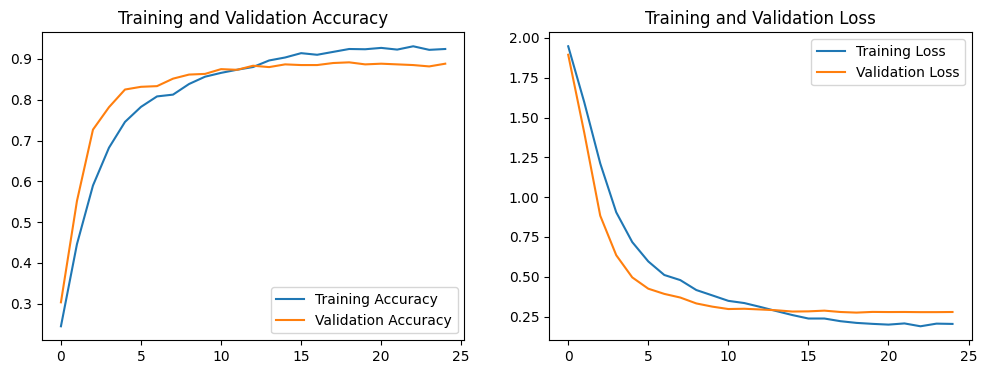

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8753 - loss: 0.3050
Test accuracy: 0.8950
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
              precision    recall  f1-score   support

          A+       0.89      0.96      0.92        57
          A-       0.90      0.82      0.86       101
         AB+       0.90      0.93      0.92        71
         AB-       0.89      0.86      0.87        76
          B+       0.94      0.92      0.93        65
          B-       0.86      0.96      0.90        74
          O+       0.89      0.88      0.89        85
          O-       0.90      0.87      0.89        71

    accuracy                        

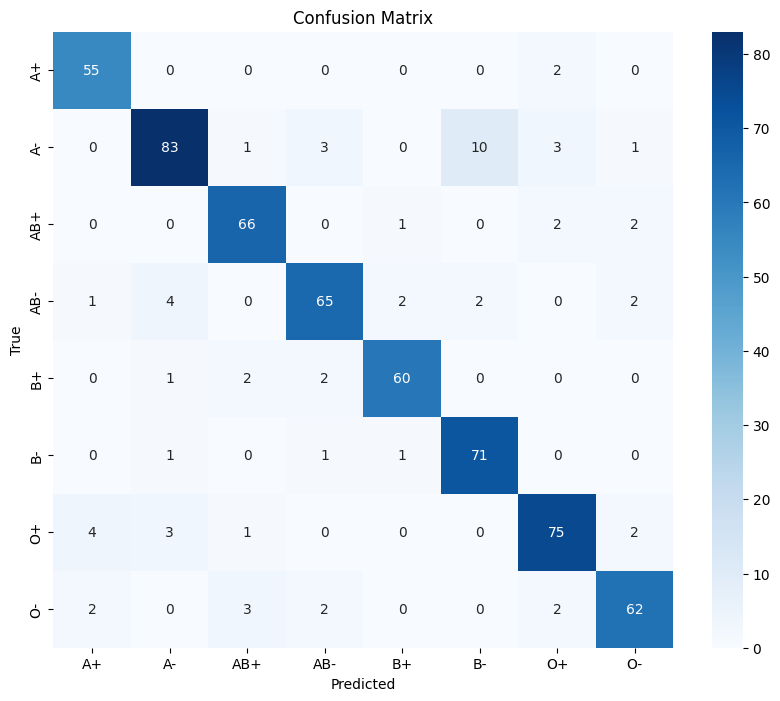

In [17]:
# Plot training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_history(history)

# Step 8: Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc:.4f}')

# Generate predictions
y_pred = []
y_true = []

for images, labels in test_ds:
    y_pred.extend(np.argmax(model.predict(images), axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [24]:
model.save('my_model.keras')

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load the trained model
model = tf.keras.models.load_model('my_model.keras')
file_path = 'cluster_1_4651.jpg'

def preprocess_image(file_path):
    """
    Preprocesses the image for ResNet50 model prediction.
    """
    # Load image in RGB mode and resize to 224x224
    img = load_img(file_path, target_size=(224, 224), color_mode='rgb')
    img_array = img_to_array(img)

    # Apply ResNet50 specific preprocessing
    img_array = preprocess_input(img_array)

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict():
    # Preprocess the image
    img = preprocess_image(file_path)

    # Perform prediction
    predictions = model.predict(img)
    predicted_class = int(np.argmax(predictions[0]))
    print('predicted_class is:', predicted_class)

    # Define class labels (must match training order)
    class_names = ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']
    predicted_label = class_names[predicted_class]
    confidence = float(np.max(predictions[0]))

    # Return the result
    res = {
        'predicted_class': predicted_class,
        'predicted_label': predicted_label,
        'confidence': confidence,
        'probabilities': predictions[0].tolist()  # Optional: all class probabilities
    }
    print(res)
    return res

if __name__ == '__main__':
    predict()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
predicted_class is: 3
{'predicted_class': 3, 'predicted_label': 'AB-', 'confidence': 0.7597705125808716, 'probabilities': [0.005149235017597675, 0.15052147209644318, 0.004210104234516621, 0.7597705125808716, 0.008419510908424854, 0.01849191263318062, 0.018842093646526337, 0.03459516540169716]}
